# This tutorial is running on Geforce GTX 1080Ti 12GB

## Load Basic Library

In [1]:
import math
import numpy as np
import tensorflow as tf

## Set Environment and Parameters

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # use first GPU

seed = 2 # random seed
model_dir = "model_transfer/" # folder for saving model and log
resize_shape = (128, 128) # resized image size
NUM_LABELS = 12 # number of labels
BATCH_SIZE = 256 # number of images in one batch
EPOCHS = 10
SAVE_SUMMARY_STEPS = 100 # save summary to tensorboard - one step means one batch
NUM_GPUS = 1 # number of GPU

## Load Data
See Analyze.ipynb  
dataset from: https://www.kaggle.com/c/plant-seedlings-classification

In [3]:
import pickle

pickle_file = 'train_val10_{1}*{1}_seed{0}.pickle'.format(seed, resize_shape[0])

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    train_dataset = train_dataset.astype("float32")
    valid_dataset = valid_dataset.astype("float32")
    train_dataset /= 255
    valid_dataset /= 255
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (4630, 128, 128, 3) (4630,)
Validation set (120, 128, 128, 3) (120,)


## Label Encoder

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
valid_labels = encoder.transform(valid_labels)
encoder.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

## Image Augmentation (Keras)

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(train_dataset)

# Fit the model on the batches generated by datagen.flow().
generator = datagen.flow(train_dataset, train_labels,
                         batch_size=1, seed=seed)

## Feed Training Data to Model (Keras)

In [6]:
def train_input_fn_keras(generator):
    gen_fn = lambda: generator
    
    dataset = tf.data.Dataset.from_generator(gen_fn, (tf.float32, tf.int64))
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.repeat(EPOCHS)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(None)
    
    iterator = dataset.make_one_shot_iterator()
    
    features, labels = iterator.get_next()
    features = tf.reshape(features, [-1, 128, 128, 3])
    print("output feature:", features.shape)
    
    tf.summary.image("images", features)
    
    return features, labels

## Feed Evaluation Data to Model

In [7]:
def eval_input_fn(features, labels):
    
    def make_generator(images, labels):

        def _generator():
            for image, label in zip(images, labels):
                yield image, label

        return _generator
    
    dataset = tf.data.Dataset.from_generator(make_generator(features, labels), (tf.float32, tf.int64))
    dataset = dataset.batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    
    features, labels = iterator.get_next()
    features = tf.reshape(features, [-1, 128, 128, 3])
    
    return features, labels

## Model Structure
1. Tensorflow initail weight will use ```tf.global_variables_initializer()```, but it will destroy the pretrained weights. So save the pretrained weights
2. Do not use keras way to get features on Keras pretrained model, i.e. ```features = model(feature)```. It will get duplicate graph  
   Use the follwing code instead  
   ```python
   features = tf.identity(model.layers[-1].output, name='vgg16_output')
   ```
Reference: http://zachmoshe.com/2017/11/11/use-keras-models-with-tf.html 
2. Because we use Keras model, so running in Tensorflow original session will not get pretrained weights. Use ```tf.keras.backend.get_session()``` instead  
Reference: https://github.com/keras-team/keras/issues/8438 

In [8]:
weights = "imagenet"
def vgg16(features, training):
    global weights
    
    with tf.variable_scope("vgg16"):
        model = tf.keras.applications.VGG16(include_top=False, weights=weights, input_tensor=features, input_shape=(128, 128, 3))
    # Only load imagenet weight on the first run
    if weights=="imagenet":
        sess = tf.keras.backend.get_session()
        vgg_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg16')
        tf.train.Saver(vgg_weights).save(sess, "pretrained_model/vgg16.ckpt")
        weights = None
    features = tf.identity(model.layers[-1].output, name='vgg16_output')
    features = tf.keras.layers.Flatten(name="flatten")(features)
    with tf.variable_scope("fine_tune"):
        features = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.relu, name="dense1")(features)
        features = tf.keras.layers.Dropout(rate=0.5, name="dropout1")(features)
        features = tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu, name="dense2")(features)
        features = tf.keras.layers.Dropout(rate=0.5, name="dropout2")(features)
        logits = tf.keras.layers.Dense(units=NUM_LABELS, name="output")(features)
    return logits

## Model Function for tf.Estimator
**Remember: set ```tf.keras.backend.set_learning_phase```. It will allow Keras model to update weights**  
1. To save model for tensorflow serving, set **`export_outputs`** parameter in prediction mode
2. We want to freeze the imagenet weights, update the fully connected layer  
   Use follwing code instead  
   ```python
   train_op = optimizer.minimize(loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fine_tune'), global_step=tf.train.get_global_step())
    ```

In [9]:
def model_fn(features, labels, mode):
    
    # to save model for tensorflow serving
    if isinstance(features, dict):
        features = features['image']
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        training = True
        tf.keras.backend.set_learning_phase(True)
    else:
        training = False
        tf.keras.backend.set_learning_phase(False)
    
    logits = vgg16(features, training)
    
    predicted_class = tf.argmax(logits, axis=1)
    
    # Prediction mode for tensorflow serving
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            "class_ids": predicted_class[:, tf.newaxis],
            "probability": tf.nn.softmax(logits),
            "logits": logits
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions, export_outputs={ 
            'classify': tf.estimator.export.PredictOutput(predictions)})
    
    # calculate cross entropy loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    def _f1_score(labels, predictions, class_id):
        """
        Reference: https://stackoverflow.com/questions/45603956/class-wise-precision-and-recall-for-multi-class-classification-in-tensorflow
        """
        precision = tf.metrics.precision_at_k(labels, predictions, 1, class_id)
        recall = tf.metrics.recall_at_k(labels, predictions, 1, class_id)
        f1_score = 2 * (precision[0] * recall[0]) / (precision[0] + recall[0])
        f1_score_op = 2 * (precision[1] * recall[1]) / (precision[1] + recall[1])
        return (f1_score, f1_score_op)
    
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_class, name="accuracy")
    f1_score_BlackGrass = _f1_score(labels=labels, predictions=logits, class_id=0)
    metrics = {"accuracy" : accuracy, "f1_score_BlackGrass" : f1_score_BlackGrass}
    tf.summary.scalar("accuracy", accuracy[1])
    tf.summary.scalar("f1_score_BlackGrass", f1_score_BlackGrass[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        
        # for multiple GPUs
        # optimizer = tf.contrib.estimator.TowerOptimizer(optimizer)
        
        # for batch normalization, tell tensorflow update batch normalization mean and variance
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fine_tune'), global_step=tf.train.get_global_step())
            
        # normal version
        #train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
        
        # monitor trianing information
        logging_hook = tf.train.LoggingTensorHook({"loss" : loss, 
                                                   "accuracy" : accuracy[1], 
                                                   "f1_score_BlackGrass" : f1_score_BlackGrass[1]}, 
                                                  every_n_iter=SAVE_SUMMARY_STEPS)
        
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op, training_hooks=[logging_hook])
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

## For Multiple GPU (Parallel Computing)
Testing, not stable version  
Evaluation is not yet distributed

In [10]:
def get_distribution_strategy(num_gpus, all_reduce_alg=None):
    """Return a DistributionStrategy for running the model.
    Args:
    num_gpus: Number of GPUs to run this model.
    all_reduce_alg: Specify which algorithm to use when performing all-reduce.
      See tf.contrib.distribute.AllReduceCrossTowerOps for available algorithms.
      If None, DistributionStrategy will choose based on device topology.
    Returns:
    tf.contrib.distribute.DistibutionStrategy object.
    """
    if num_gpus == 0:
        return tf.contrib.distribute.OneDeviceStrategy("device:CPU:0")
    elif num_gpus == 1:
        return tf.contrib.distribute.OneDeviceStrategy("device:GPU:0")
    else:
        if all_reduce_alg:
            return tf.contrib.distribute.MirroredStrategy(
                num_gpus=num_gpus,
                cross_tower_ops=tf.contrib.distribute.AllReduceCrossTowerOps(
                    all_reduce_alg, num_packs=num_gpus))
        else:
            return tf.contrib.distribute.MirroredStrategy(num_gpus=num_gpus)

## Set Runing Config
Load pretrained weight
```python
ws = tf.estimator.WarmStartSettings(ckpt_to_initialize_from="pretrained_model",
                                    vars_to_warm_start="vgg16.*")
```

In [11]:
session_config = tf.ConfigProto()
session_config.gpu_options.per_process_gpu_memory_fraction = 0.8
session_config.gpu_options.allow_growth = True
config = tf.estimator.RunConfig(model_dir=model_dir, 
                                tf_random_seed=seed, 
                                save_summary_steps=SAVE_SUMMARY_STEPS, 
                                save_checkpoints_steps=SAVE_SUMMARY_STEPS, 
                                session_config=session_config,
                                keep_checkpoint_max=5, 
                                log_step_count_steps=100, )
#                                train_distribute=get_distribution_strategy(NUM_GPUS)) #for mutiple GPUs
ws = tf.estimator.WarmStartSettings(ckpt_to_initialize_from="pretrained_model",
                                    vars_to_warm_start="vgg16.*")
clf = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_dir, config=config, warm_start_from=ws)

INFO:tensorflow:Using config: {'_evaluation_master': '', '_global_id_in_cluster': 0, '_tf_random_seed': 2, '_log_step_count_steps': 100, '_device_fn': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_task_id': 0, '_master': '', '_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_model_dir': 'model_transfer/', '_task_type': 'worker', '_save_checkpoints_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c3b979da0>, '_save_summary_steps': 100, '_train_distribute': None, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.8
  allow_growth: true
}
}


## Train and Evaluate

In [12]:
train_spec = tf.estimator.TrainSpec(lambda:train_input_fn_keras(generator), max_steps=1800)
eval_spec = tf.estimator.EvalSpec(lambda:eval_input_fn(valid_dataset, valid_labels), throttle_secs=300)
tf.estimator.train_and_evaluate(clf, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 100 or save_checkpoints_secs None.
output feature: (?, 128, 128, 3)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='pretrained_model', vars_to_warm_start='vgg16.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('pretrained_model',)
INFO:tensorflow:Warm-starting variable: vgg16/block5_conv2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: vgg16/block1_conv2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: vgg16/block5_conv2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: vgg16/block4_conv3/bias; 

({'accuracy': 0.675,
  'f1_score_BlackGrass': 0.33333333333333337,
  'global_step': 1800,
  'loss': 0.90106404},
 [])

## Check the pretrained weights are freezed

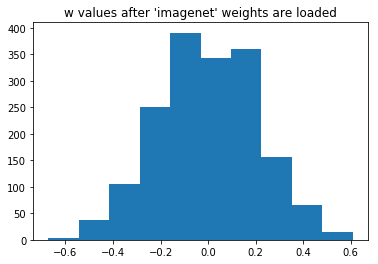

(3, 3, 3, 64)


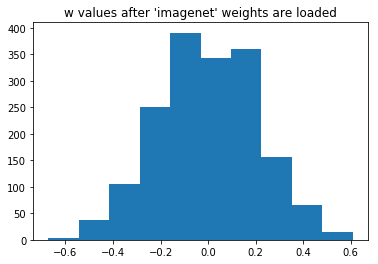

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
with tf.Session() as sess:
    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    w = vgg16.get_layer('block1_conv1').get_weights()[0]
    plt.hist(w.flatten())
    plt.title("w values after 'imagenet' weights are loaded")
    plt.show()

w = clf.get_variable_value("vgg16/block1_conv1/kernel")
print(w.shape)
plt.hist(w.flatten())
plt.title("w values after 'imagenet' weights are loaded")
plt.show()

## Save model for Tensorflow Serving
Can not save model after **predict**, because `Graph` is finalized and cannot be modified  
You can assign which model to be saved by `checkpoint_path` parameter

In [16]:
# input
image = tf.placeholder(tf.float32, shape=[None, 128, 128, 3], name='image')
# input receiver
input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({
    'image': image,
})

clf.export_savedmodel("saved_model/", input_fn, checkpoint_path="model_transfer/model.ckpt-1800")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['classify', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Restoring parameters from model_transfer/model.ckpt-1800
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: saved_model/temp-b'1536907624'/saved_model.pb


b'saved_model/1536907624'

## Load model and predict
Estimator predict method return **generator** type, so if you want to get all predictions please use for loop  
```python
for result in results:
    print(result)
```

In [17]:
results = clf.predict(lambda: eval_input_fn(valid_dataset, valid_labels), checkpoint_path="model_transfer/model.ckpt-1800")
next(results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model_transfer/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'class_ids': array([8]),
 'logits': array([-2.2231734 , -0.7330439 ,  0.63402456, -0.8422852 , -1.5529217 ,
        -0.67170465, -1.6516896 , -0.53993213,  2.340041  ,  1.1269958 ,
         0.6424718 , -1.3946064 ], dtype=float32),
 'probability': array([0.00540818, 0.02399974, 0.09417091, 0.0215161 , 0.01057154,
        0.02551795, 0.00957731, 0.02911212, 0.5185973 , 0.15417412,
        0.09496976, 0.01238493], dtype=float32)}

## Load model from `Estimator.export_savedmodel`
Reference: https://qiita.com/parkkiung123/items/13adb482860f356f97f3  

In [18]:
import tensorflow as tf
import numpy as np

export_dir = 'saved_model/1536907624'

with tf.Session(graph=tf.Graph()) as sess:
    # saved_model load
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)
    # input
    i = sess.graph.get_tensor_by_name("image:0")
    # output
    r = sess.graph.get_tensor_by_name("ArgMax:0")
    print(sess.run(r, feed_dict={i:valid_dataset}))

INFO:tensorflow:Restoring parameters from saved_model/1536907624/variables/variables
[ 8  8  8  8  8  6  8  6  8  6  4 11  7 11 11 11  1  7  5 11  4  6  6  6
  4  4  4  4  6  6  1  1  1  1  1  1  1  1  1  1 10 10 10 10 10 10 10 10
 10 10  6  6  6  6  6  6  6  6  6  6  7  3  7  7  7  7  7  7  7  7  9  8
  3 10  9  9  8  9  8 10  3  3  3  3  3  3  3  8  3  3  6  6  5  1  5  5
  1  5  1  1  2  3  2  3  2  5  2  2  2  7  6  6  6  6  4  0  0  6  6  6]


## CNN Visualization
Reference: https://github.com/InFoCusp/tf_cnnvis  
Although you put multiple images, it only draws one image for visulization

In [19]:
import time
from tf_cnnvis import tf_cnnvis

# activation visualization
layers = ['r', 'p', 'c']

start = time.time()
image = sess.graph.get_tensor_by_name("image:0")
with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)
    # with sess_graph_path = None, the default Session will be used for visualization.
    is_success = tf_cnnvis.activation_visualization(sess_graph_path = None, value_feed_dict = {image : valid_dataset[10:11]}, 
                                                    layers=layers, path_logdir=os.path.join("Log","VGGNet"), 
                                                    path_outdir=os.path.join("Output","VGGNet"))
start = time.time() - start
print("Total Time = %f" % (start))

INFO:tensorflow:Restoring parameters from saved_model/1536907624/variables/variables
INFO:tensorflow:Restoring parameters from model/tmp-model
Reconstruction Completed for vgg16/block1_conv1/Relu layer. Time taken = 0.291235 s
Reconstruction Completed for vgg16/block1_conv2/Relu layer. Time taken = 0.253113 s
Reconstruction Completed for vgg16/block2_conv1/Relu layer. Time taken = 0.122363 s
Reconstruction Completed for vgg16/block2_conv2/Relu layer. Time taken = 0.142927 s
Reconstruction Completed for vgg16/block3_conv1/Relu layer. Time taken = 0.078881 s
Reconstruction Completed for vgg16/block3_conv2/Relu layer. Time taken = 0.095986 s
Reconstruction Completed for vgg16/block3_conv3/Relu layer. Time taken = 0.072141 s
Reconstruction Completed for vgg16/block4_conv1/Relu layer. Time taken = 0.074723 s
Reconstruction Completed for vgg16/block4_conv2/Relu layer. Time taken = 0.086658 s
Reconstruction Completed for vgg16/block4_conv3/Relu layer. Time taken = 0.056931 s
Reconstruction Co

In [20]:
import time
from tf_cnnvis import tf_cnnvis

# deconv visualization
layers = ['r', 'p', 'c']

start = time.time()
image = sess.graph.get_tensor_by_name("image:0")
with tf.Session(graph=tf.Graph()) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)
    is_success = tf_cnnvis.deconv_visualization(sess_graph_path = None, value_feed_dict = {image : valid_dataset[10:11]}, 
                                                layers=layers, path_logdir=os.path.join("Log","VGGNet"), 
                                                path_outdir=os.path.join("Output","VGGNet"))
start = time.time() - start
print("Total Time = %f" % (start))

INFO:tensorflow:Restoring parameters from saved_model/1536907624/variables/variables
INFO:tensorflow:Restoring parameters from model/tmp-model
Reconstruction Completed for vgg16/block1_conv1/Relu layer. Time taken = 0.548123 s
Reconstruction Completed for vgg16/block1_conv2/Relu layer. Time taken = 0.899879 s
Reconstruction Completed for vgg16/block2_conv1/Relu layer. Time taken = 1.293494 s
Reconstruction Completed for vgg16/block2_conv2/Relu layer. Time taken = 1.719456 s
Reconstruction Completed for vgg16/block3_conv1/Relu layer. Time taken = 2.905643 s
Reconstruction Completed for vgg16/block3_conv2/Relu layer. Time taken = 3.238812 s
Reconstruction Completed for vgg16/block3_conv3/Relu layer. Time taken = 3.525879 s
Reconstruction Completed for vgg16/block4_conv1/Relu layer. Time taken = 6.416328 s
Reconstruction Completed for vgg16/block4_conv2/Relu layer. Time taken = 6.691745 s
Reconstruction Completed for vgg16/block4_conv3/Relu layer. Time taken = 6.492911 s
Reconstruction Co